In [64]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs
import cartopy as cart
import cmocean
from matplotlib.animation import FuncAnimation
import numpy.fft as fft
import matplotlib.ticker as ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear, ReLU,Conv2d
from itertools import *

def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

device = "cuda"

In [54]:
class data_CNN_normalize(torch.utils.data.Dataset):

    def __init__(self,data_in,data_out,device = "cuda"):

        super().__init__()
        num_inputs = data_in.shape[1]
        num_outputs = data_out.shape[1]
        self.size = data_in.shape[0]
        
        data_in = np.nan_to_num(data_in)
        data_out = np.nan_to_num(data_out)
        
        std_data = np.nanstd(data_in,axis=(0,2,3))
        mean_data = np.nanmean(data_in,axis=(0,2,3)) 
        std_label = np.nanstd(data_out,axis=(0,2,3))
        mean_label = np.nanmean(data_out,axis=(0,2,3))
        
        for i in range(num_inputs):
            data_in[:,i,:,:] = (data_in[:,i,:,:,] - mean_data[i])/std_data[i]
        
        for i in range(num_outputs):
            data_out[:,i,:,:] = (data_out[:,i,:,:] - mean_label[i])/std_label[i]
            
        data_in = torch.from_numpy(data_in).type(torch.float32).to(device=device)
        data_out = torch.from_numpy(data_out).type(torch.float32).to(device=device)        
        

        std_dict = {'s_in':std_data,'s_out':std_label,'m_in':mean_data, 'm_out':mean_label}
            
        self.input = data_in
        self.output = data_out
        
        self.norm_vals = std_dict
        
    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_in = self.input[idx]
        label = self.output[idx]
        return data_in, label
    
# basic training loop 
# model = the model you are training
# train_loader = dataloader from the training dataset, see below 
# test_loader = dataloader from the test dataset, see below 
# num_epochs = number of update steps of the model. In each step, the model will see the full dataset
# loss = loss function chosen of the form (scalar = loss(pred,true))
# optim = optimizer that will update your network

def train(model, train_loader, test_loader, num_epochs, loss_fn, optim):
    # Set up the loss and the optimizer
    recon_loss = torch.nn.MSELoss()
    for epoch in range(num_epochs):
        for data, label in train_loader:
            optimizer.zero_grad()
            outs,mu,logvar = model(data)

            loss = loss_func(label, outs, mu, logvar) # no train_mask!
            loss.backward()
            optimizer.step()
        for data, label in test_loader:
            outs,mu,logvar = model(data)
            loss_val = recon_loss(outs, label) # no train_mask!
        if epoch%2==0:    
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Val Loss: {loss_val}')

In [58]:
class Conv_block(torch.nn.Module):

    def __init__(self,num_in = 2, num_out = 2,kernel_size = 3, num_layers=1, pad = "constant"):
        super().__init__()
        self.N_in = num_in
        self.N_pad = int((kernel_size-1)/2)
        self.pad = pad
        
        layers = []
        layers.append(torch.nn.Conv2d(num_in,num_out,kernel_size))
        layers.append(torch.nn.ReLU())
        for _ in range(num_layers-1):
            layers.append(torch.nn.Conv2d(num_out,num_out,kernel_size))
            layers.append(torch.nn.ReLU())              

        self.layers = nn.ModuleList(layers)
        #self.layers = nn.ModuleList(layer)

    def forward(self,fts):
        for l in self.layers:
            if isinstance(l,nn.Conv2d):
                fts = torch.nn.functional.pad(fts,(self.N_pad,self.N_pad,0,0),mode=self.pad)
                fts = torch.nn.functional.pad(fts,(0,0,self.N_pad,self.N_pad),mode="constant")
            fts= l(fts)
        return fts
    
class Decoder(torch.nn.Module):
    def __init__(self,ch_width,embed_dim = 20,size=[64,128],kernel_size = 3,pad = "constant"):
        super().__init__()
        self.N_in = ch_width[0]
        self.N_out = ch_width[-1]
        self.size = size
        self.N_pad = int((kernel_size-1)/2)
        self.pad = pad
        self.linear_size = int(self.N_out*(size[0]/(2**len(ch_width[:-1])))*(size[1]/(2**len(ch_width[:-1]))))

        # going down
        layers = []
        layers.append(nn.Linear(embed_dim,
                                self.linear_size))
        layers.append(nn.GELU())
        layers.append(nn.Unflatten(1,(self.N_out,int(size[0]/(2**len(ch_width[:-1]))),
                                      int(size[1]/(2**len(ch_width[:-1]))))))
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
        ch_width.reverse()
        for a,b in pairwise(ch_width[:-1]):
            layers.append(Conv_block(a,b,pad=pad))
            layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
        layers.append(Conv2d(b,self.N_in,kernel_size))

        
        self.layers = nn.ModuleList(layers)
        self.num_steps = int(len(ch_width)-1)
        
        #self.layers = nn.ModuleList(layer)

    def forward(self,fts):
        for l in self.layers:
            if isinstance(l,nn.Conv2d):
                fts = torch.nn.functional.pad(fts,(self.N_pad,self.N_pad,0,0),mode=self.pad)
                fts = torch.nn.functional.pad(fts,(0,0,self.N_pad,self.N_pad),mode="constant")
            fts= l(fts)
            
        return fts 
    
class Encoder(torch.nn.Module):
    def __init__(self,ch_width,embed_dim = 20,size=[64,128],kernel_size = 3,pad = "constant"):
        super().__init__()
        self.N_in = ch_width[0]
        self.N_out = ch_width[-1]
        self.N_pad = int((kernel_size-1)/2)
        self.pad = pad
        self.size = size
        self.linear_size = int(self.N_out*(size[0]/(2**len(ch_width[:-1])))*(size[1]/(2**len(ch_width[:-1]))))
        
        # going down
        layers = []
        for a,b in pairwise(ch_width):
            layers.append(Conv_block(a,b,pad=pad))
            layers.append(nn.MaxPool2d(2))
            
        layers.append(torch.nn.Flatten())
        layers.append(nn.Linear(self.linear_size,
                                embed_dim))  
        layers.append(nn.GELU())
        self.layers = nn.ModuleList(layers)
        self.mu = nn.Linear(embed_dim,
                        embed_dim)
        self.logvar = nn.Linear(embed_dim,
                        embed_dim)        
        self.num_steps = int(len(ch_width)-1)
        
        #self.layers = nn.ModuleList(layer)

    def forward(self,fts):
        for l in self.layers:            
            if isinstance(l,nn.Conv2d):
                fts = torch.nn.functional.pad(fts,(self.N_pad,self.N_pad,0,0),mode=self.pad)
                fts = torch.nn.functional.pad(fts,(0,0,self.N_pad,self.N_pad),mode="constant")
            fts= l(fts)
        mu = self.mu(fts)
        logvar = self.logvar(fts)
        fts =  mu + torch.exp(logvar/2) * torch.randn_like(logvar)

        return fts, mu, logvar   
    
class Encoder_Decoder(torch.nn.Module):
    def __init__(self,ch_width,embed_dim = 20,size=[64,128],kernel_size = 3,pad = "constant"):
        super().__init__()
        self.N_in = ch_width[0]
        self.N_out = ch_width[-1]
        self.N_pad = int((kernel_size-1)/2)
        self.pad = pad
        
        self.encoder = Encoder(ch_width,embed_dim,size,kernel_size,pad)
        self.decoder = Decoder(ch_width,embed_dim,size,kernel_size,pad)

        # going down
        layers = []

        layers.append(self.encoder)
        layers.append(self.decoder)
        self.layers = nn.ModuleList(layers)
        
        self.num_steps = int(len(ch_width)-1)
        
        #self.layers = nn.ModuleList(layer)

    def forward(self,fts):
        fts, mu, logvar = self.encoder(fts)
        fts = self.decoder(fts)

        return fts,mu,logvar  
    
            

In [62]:
def loss_func(out, pred, mu, logvar,lam = .00025):
    mse = torch.nn.MSELoss()
    recon_loss = mse(out,pred)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + lam  * kl_loss

In [31]:
data = xr.open_zarr("/scratch/as15415/Data/Emulation_Data/Global_Ocean_1deg.zarr/")
data = data["T"]

# data_1 = data.sel(xu_ocean = slice(35,80))
# data_2 = data.sel(xu_ocean = slice(-280,-235))
# data_2["xu_ocean"] = data_2["xu_ocean"].data+360
# data = xr.concat([data_1,data_2],dim = "xu_ocean")
# data = data.sel(yu_ocean = slice(-40,30))

# Pacific


data = data.sel(xu_ocean = slice(-208,-80),yu_ocean = slice(-31,30))

wet =np.isnan(data[0])
wet = xr.where(wet==0,np.nan,0)    
wet = np.isnan(wet)
wet = np.nan_to_num(wet.to_numpy())
wet_bool = np.array(wet).astype(bool)

locs = np.argwhere(wet_bool)

Nx = data.xu_ocean.data.size
Ny = data.yu_ocean.data.size


In [8]:
clim = np.array(data.groupby('time.dayofyear').mean('time').compute())
# clim = clim.mean(axis = [1,2])

In [9]:
data_network = data[:7305].to_numpy()
for i in range(7305):
    day_yr = data.time.data[i].dayofyr-1
    data_network[i] = data_network[i]- clim[day_yr]

In [10]:
data_network = np.expand_dims(data_network,1)

In [11]:
train_data = data_CNN_normalize(data_network[:7305],data_network[:7305],device = device)
val_data = data_CNN_normalize(data_network[5000:5500],data_network[5000:5500],device = device)

In [12]:
# this may need to be kept smaller
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=10)


In [63]:
model = Encoder_Decoder([1,100,50,25,10],embed_dim=20)
model = model.to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# define a loss function
loss = torch.nn.MSELoss()

# train the model (just pass in everthing that we have defined previously)
# Note that your problems will likely require far fewer epochs for convergence

train(model, train_loader, test_loader, 45, loss, optimizer)

[Epoch 1/45] Loss: 0.6077789664268494 | Val Loss: 0.8104228973388672
[Epoch 3/45] Loss: 0.5508260726928711 | Val Loss: 0.7071725726127625
[Epoch 5/45] Loss: 0.44391191005706787 | Val Loss: 0.697629451751709
[Epoch 7/45] Loss: 0.42255696654319763 | Val Loss: 0.6755949854850769
[Epoch 9/45] Loss: 0.4292469024658203 | Val Loss: 0.6383865475654602
[Epoch 11/45] Loss: 0.43239036202430725 | Val Loss: 0.5944080352783203
[Epoch 13/45] Loss: 0.41607820987701416 | Val Loss: 0.5291043519973755
[Epoch 15/45] Loss: 0.4102705419063568 | Val Loss: 0.49879416823387146
[Epoch 17/45] Loss: 0.4099087715148926 | Val Loss: 0.4719989001750946
[Epoch 19/45] Loss: 0.39864230155944824 | Val Loss: 0.44691362977027893
[Epoch 21/45] Loss: 0.3910951018333435 | Val Loss: 0.4394097328186035
[Epoch 23/45] Loss: 0.3908606171607971 | Val Loss: 0.4554177224636078
[Epoch 25/45] Loss: 0.3966156840324402 | Val Loss: 0.4434483051300049
[Epoch 27/45] Loss: 0.3957494795322418 | Val Loss: 0.436943918466568
[Epoch 29/45] Loss: 

In [68]:
embed_space = torch.zeros((7305,20))

with torch.no_grad():
    a,embed_space[:4000],a = model.encoder(train_data[:4000][0])
    a,embed_space[4000:],a = model.encoder(train_data[4000:][0])
embed_space = embed_space.cpu()

In [69]:
U, S, V = np.linalg.svd(embed_space, full_matrices=False)

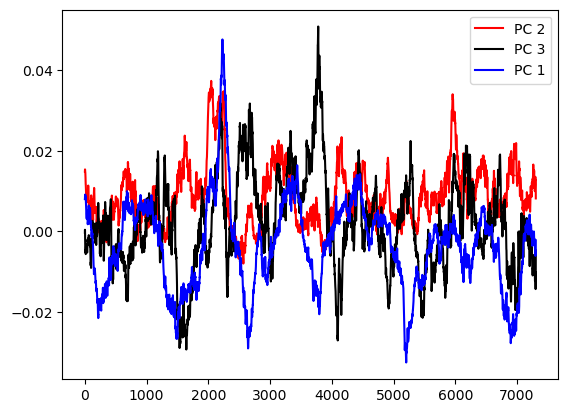

In [70]:
plt.plot(U[:,1],"r",label = "PC 2")
plt.plot(U[:,2],"k",label = "PC 3")
plt.plot(U[:,0],"b",label = "PC 1")

plt.legend()

In [71]:
V = torch.from_numpy(V).type(torch.float32).to(device = device)

In [72]:
with torch.no_grad():
    PC1 = model.decoder(torch.unsqueeze(V[0,:],0)).cpu()


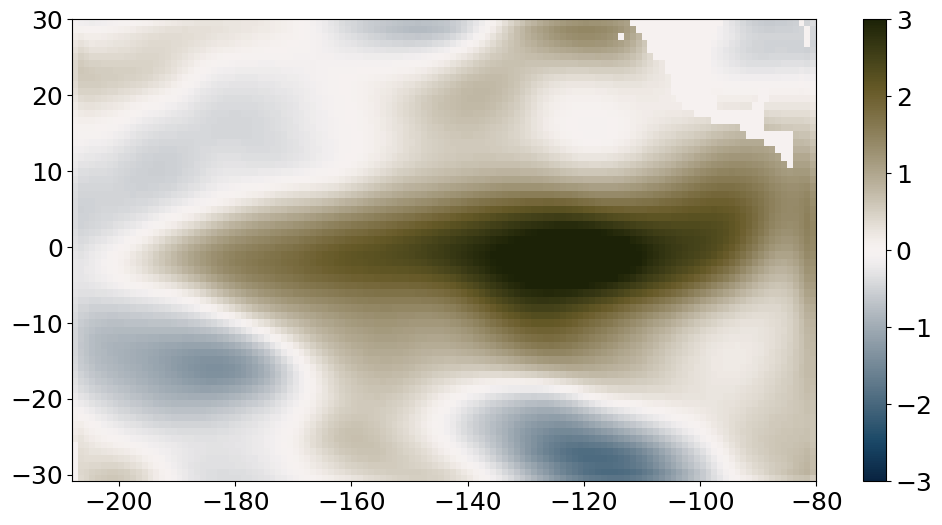

In [78]:
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)

fig, axs = plt.subplots(1, 1, figsize=(12,6),
                        gridspec_kw={'width_ratios': [1], 'height_ratios': [1], 'wspace': 0.25,'hspace':.5},
                       )

plt.pcolor(data.xu_ocean,data.yu_ocean,PC1.cpu().squeeze()*wet_bool,vmax = 3,vmin=-3,cmap=cmocean.cm.diff)
plt.colorbar()


In [79]:
with torch.no_grad():
    PC2 = model.decoder(torch.unsqueeze(V[1,:],0)).cpu()



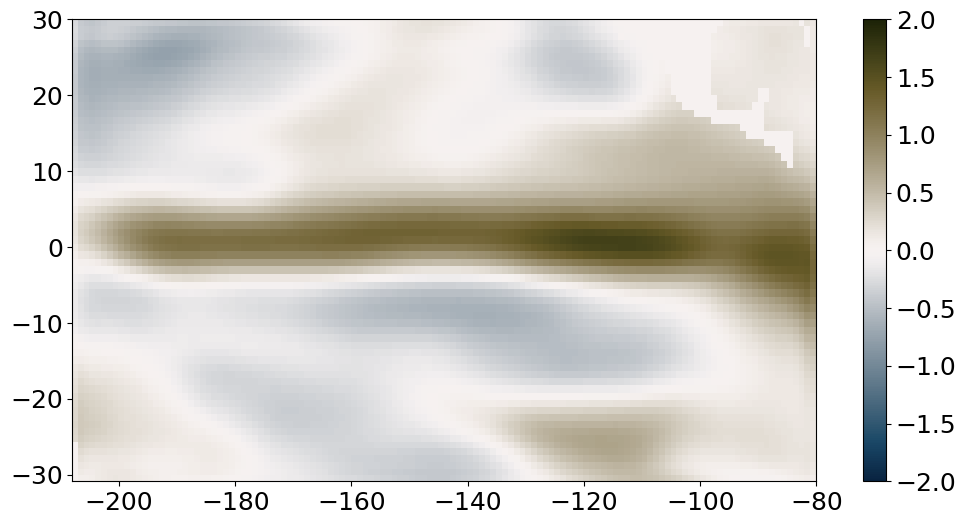

In [81]:
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)

fig, axs = plt.subplots(1, 1, figsize=(12,6),
                        gridspec_kw={'width_ratios': [1], 'height_ratios': [1], 'wspace': 0.25,'hspace':.5},
                       )

plt.pcolor(data.xu_ocean,data.yu_ocean,PC2.cpu().squeeze()*wet_bool,vmax = 2,vmin=-2,cmap=cmocean.cm.diff)
plt.colorbar()

In [82]:
with torch.no_grad():
    PC3 = model.decoder(torch.unsqueeze(V[2,:],0)).cpu()

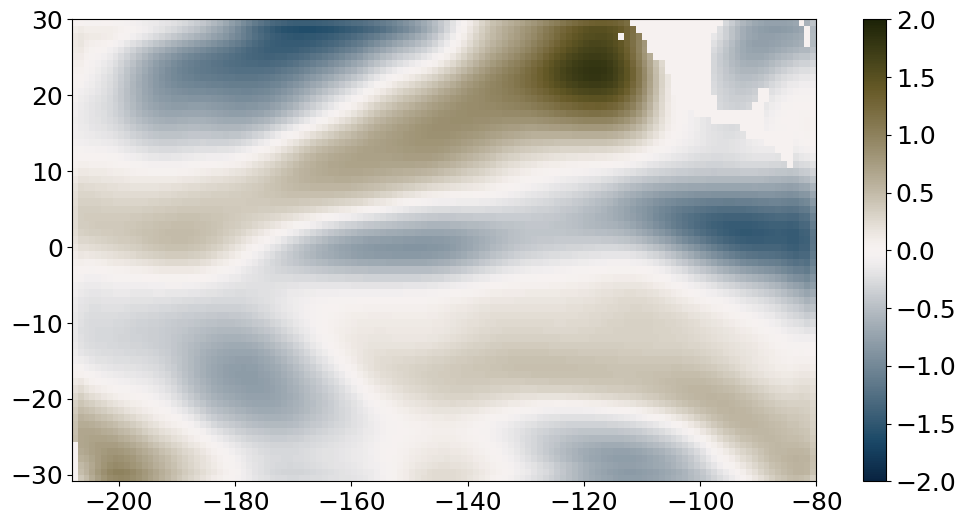

In [84]:
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)

fig, axs = plt.subplots(1, 1, figsize=(12,6),
                        gridspec_kw={'width_ratios': [1], 'height_ratios': [1], 'wspace': 0.25,'hspace':.5},
                       )

plt.pcolor(data.xu_ocean,data.yu_ocean,PC3.cpu().squeeze()*wet_bool,vmax = 2,vmin=-2,cmap=cmocean.cm.diff)
plt.colorbar()

In [93]:
with torch.no_grad():
    test_reconstruct,a,a = model(train_data[:1000][0])
test_reconstruct = test_reconstruct.cpu()

Text(0.5, 1.0, 'Reconstruction')

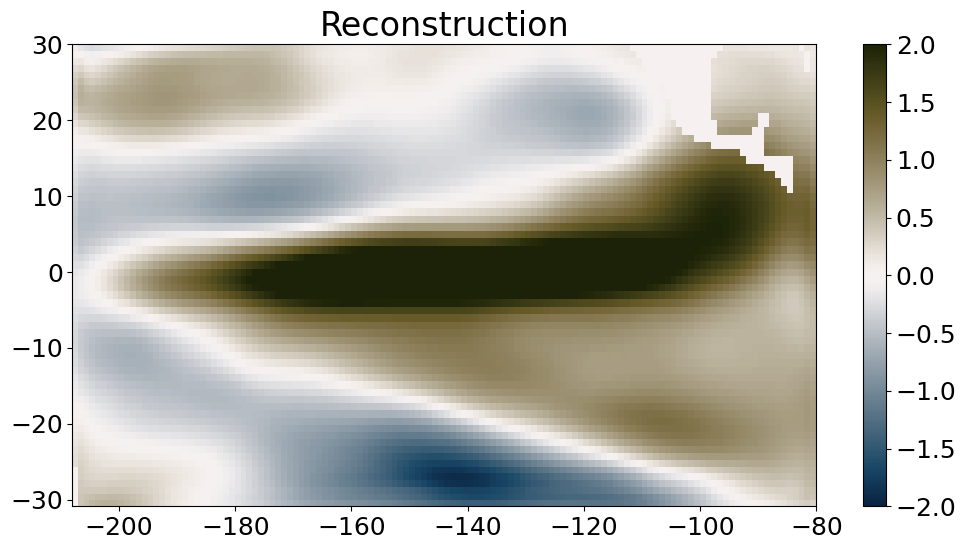

In [102]:
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)

fig, axs = plt.subplots(1, 1, figsize=(12,6),
                        gridspec_kw={'width_ratios': [1], 'height_ratios': [1], 'wspace': 0.25,'hspace':.5},
                       )

plt.pcolor(data.xu_ocean,data.yu_ocean,test_reconstruct[0].squeeze()*wet_bool,vmax = 2,vmin=-2,cmap=cmocean.cm.diff)
plt.colorbar()
plt.title("Reconstruction",fontsize=24)

Text(0.5, 1.0, 'Ground Truth')

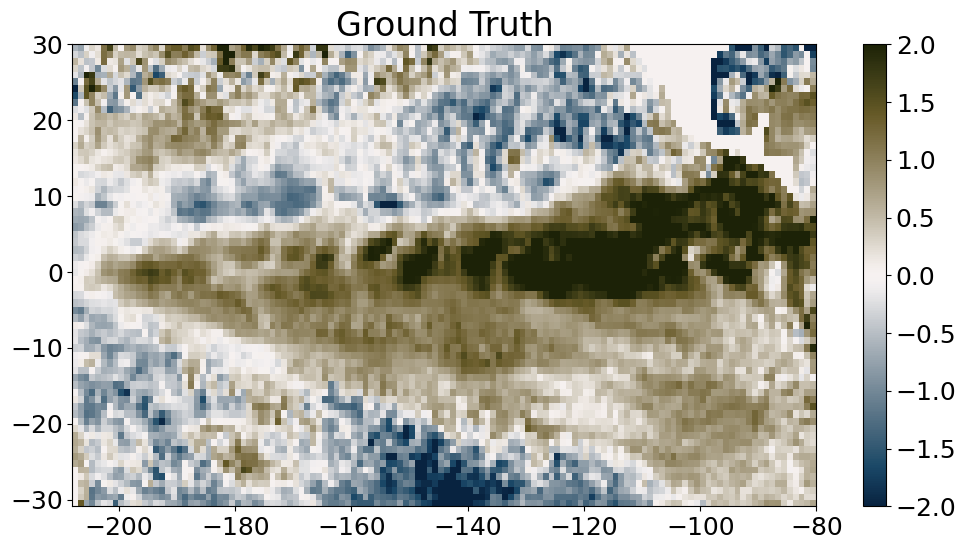

In [101]:
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)

fig, axs = plt.subplots(1, 1, figsize=(12,6),
                        gridspec_kw={'width_ratios': [1], 'height_ratios': [1], 'wspace': 0.25,'hspace':.5},
                       )

plt.pcolor(data.xu_ocean,data.yu_ocean,train_data[0][0].cpu().squeeze()*wet_bool,vmax = 2,vmin=-2,cmap=cmocean.cm.diff)
plt.colorbar()
plt.title("Ground Truth",fontsize=24)